In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from torch.optim import Adam

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Action model definition

In [3]:
class ActionModel():
    def __init__(self, network):
        self.network = network
        self.optimizer = Adam(self.network.parameters(), lr=1e-4)
        self.scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.999)
        
        self.sigma = torch.tensor(25., device=device)
        
    def diff_coeff(self,t):
        return self.sigma**t
    
    def p_0t_standard_deviation(self,t):
        return torch.sqrt( (self.sigma**(2. * t) - 1.) / (2. * torch.log(self.sigma)) )
    
    def draw_init_config(self,n):
        # n: number of samples
        randn = torch.randn((n,1), device=device)
        t = torch.tensor((1.), device=device)
        return randn * self.p_0t_standard_deviation(t)
    
    def generate_samples(self, n, eps=2e-4):
        # n: Number of samples to be generated
        # eps: step size
        self.network.eval()

        phi = self.draw_init_config(n) # Draw from the prior distribution
        for i in range(int(1./eps)):
            t = 1. - i * eps
            t_batch = torch.ones((phi.shape[0],1), device=device) * t

            phi = phi.detach()
            phi.requires_grad = True
            action = self.network(phi, t_batch)
            score = torch.autograd.grad(torch.sum(action), phi)[0].detach()
            phi = phi + eps * self.sigma**(2*t) * score + self.sigma**t * np.sqrt(eps) * torch.randn_like(phi)
            # No *sqrt(2) behind the randn as compared to the SQ method
        return phi.detach()
    
    def loss_function_action(self, x_0):
        eps = 1e-5
        t = torch.rand((x_0.shape[0], 1), device=device) * (1. - eps) + eps #Second part for numerical stability
        lam_sqrt = self.p_0t_standard_deviation(t).view(x_0.shape[0],1)
        std_normal_dist = torch.randn_like(x_0, device=device)
        x_t = x_0 + lam_sqrt * std_normal_dist
        
        self.network.train()
        x_t = x_t.detach()
        x_t.requires_grad = True
        action = self.network(x_t, t)
        score = torch.autograd.grad(torch.sum(action), x_t, create_graph=True)[0]

        loss = (std_normal_dist + score * lam_sqrt)**2
        return torch.mean(loss)
    
    def train_network(self, training_samples, n_epoch, batch_size=128):
        self.training_samples = training_samples
        n_samples = self.training_samples.shape[0]

        tqdm_epoch = trange(n_epoch)
        for n in tqdm_epoch:
            avg_loss = 0.

            num_items = 0
            rand_perm = torch.randperm(self.training_samples.shape[0])
            self.training_samples = self.training_samples[rand_perm]
            for i in range(n_samples//batch_size):
                training_batch = self.training_samples[i*batch_size:(i+1)*batch_size]
                loss = self.loss_function_action(training_batch.to(device))
                self.optimizer.zero_grad()
                loss.backward()    
                self.optimizer.step()
                avg_loss += loss.item() * batch_size
                num_items += batch_size
            self.scheduler.step()
            tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
            
    def calculate_magnetization(self, n_samples):
        # Genera un certo numero di campioni usando la funzione `generate_samples`
        samples = self.generate_samples(n_samples)
        
        # La magnetizzazione è la media dei campioni generati
        #magnetization = torch.mean(samples).item()
        magnetization = (torch.mean(abs(samples)).item())
        return magnetization
    
    def calculate_susceptibility(self, n_samples):
    # Genera campioni usando la funzione generate_samples
        samples = self.generate_samples(n_samples)
    
    # Calcola la varianza dei campioni (relativa alla magnetizzazione)
        variance_magnetization = torch.var(abs(samples))
    
    # La suscettibilità è la varianza moltiplicata per il numero di campioni
        susceptibility = variance_magnetization.item() * n_samples
        return susceptibility

# Generate training samples

The action of the system:

\begin{equation}
S(\phi) = m \phi^2 + \lambda \phi^4
\end{equation}

In [4]:
def run_sq(n, total_steps, m, lam):
    epsilon = 2e-4
    phi = torch.randn((n))
    
    for i in range(total_steps):
        drift_term = 2. * m * phi + 4. * lam * phi**3
        phi = phi - epsilon * drift_term + np.sqrt(epsilon) * torch.randn((n)) * np.sqrt(2.)
    return phi[:,None]

# Network definition

Simple network, where one would have to do a coefficient fit afterwards

In [5]:
class SimpleNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.lint = nn.Linear(1,64)
        self.lin1 = nn.Linear(1,64)
        self.lin2 = nn.Linear(64,128)
        self.lin3 = nn.Linear(128,64)
        self.lin4 = nn.Linear(64,1)
        
        self.act = nn.SiLU()

    def forward(self, x, t):
        x = self.lin1(x)
        x = self.act(x)
        t = self.lint(t)
        x += self.act(t)
        x = self.lin2(x)
        x = self.act(x)
        x = self.lin3(x)
        x = self.act(x)
        x = self.lin4(x)
        return x

Sin and Cos based network, one can read out the parameters via the parameter bool input

In [ ]:
class NetworkSinus(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.n_orders = 32 # has to be divideable by 2
        dim_lin = 64
        
        self.layer_1 = nn.ModuleList([nn.Linear(1,dim_lin) for i in range(2*self.n_orders)])
        self.layer_2 = nn.ModuleList([nn.Linear(dim_lin,1) for i in range(2*self.n_orders)])
        
        self.silu = nn.SiLU()

    def forward(self, x, t0, params_bool=True):
        
        coeffs = []
        for i in range(2*self.n_orders):
            coeff = self.layer_1[i](t0)
            coeff = self.silu(coeff)
            coeffs.append(self.layer_2[i](coeff))
            
        if params_bool:
           # print("Coefficients:", coeffs[0])  # Stampa i coefficienti
            return coeffs[2][0]
        
    
        
        else:
            action = coeffs[0] * torch.sin(coeffs[1]*x) + coeffs[2] * torch.cos(coeffs[3]*x)
            for i in range(4,self.n_orders,4):
                action += coeffs[i] * torch.sin(coeffs[i+1]*x) + coeffs[i+2] * torch.cos(coeffs[i+3]*x)
            return -action

In [ ]:
class LinearPhiSquaredPhiQuarticModel(nn.Module):
    def __init__(self):
        super(LinearPhiSquaredPhiQuarticModel, self).__init__()
        # Un layer lineare per mappare i termini \phi^2, \phi^4 e t
        self.linear = nn.Linear(3, 1, bias=False)  # 3 input: uno per \phi^2, uno per \phi^4, e uno per t
    
    def forward(self, x, t):
        # Genera le feature \phi^2 e \phi^4
        phi_features = torch.cat([x**2, x**4], dim=1)
        
        # Aggiungi t come terza feature
        t_feature = t.view(-1, 1)  # Assicurati che t abbia la dimensione corretta
        features = torch.cat([phi_features, t_feature], dim=1)
        
        # Passa attraverso il layer lineare
        return self.linear(features)


## Visualization

In [6]:
def plot_network_t(network, t, phi_max):
    grid_dim = 100
    eff_action_grid = np.zeros((grid_dim))
    t_vec = torch.ones((grid_dim, 1), device=device) * t
    eff_action_grid = - network(torch.linspace(-phi_max,phi_max,
                                                    grid_dim,device=device)[:,None], t_vec).detach().cpu().numpy().flatten()

    phi_axis = np.linspace(-phi_max,phi_max,grid_dim)

    fig, ax = plt.subplots(figsize=(9,9))
    ax.plot(phi_axis,eff_action_grid)
    ax.grid()
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel(r'$S_{\theta}(\phi,t)$')
    ax.set_title(r'$t=$%f'%t)
    plt.show()

In [7]:
def plot_network(network, phi_max):
    grid_dim = 100
    eff_action_grid = np.zeros((grid_dim,grid_dim))
    for i in range(grid_dim):
        t = torch.ones(grid_dim,1, device=device) * i / grid_dim
        eff_action_grid[i] = - network(torch.linspace(-phi_max,phi_max,
                                                      grid_dim,device=device)[:,None], t).detach().cpu().numpy().flatten()
        eff_action_grid[i] = eff_action_grid[i] - eff_action_grid[i,-1] # Optional, fixes purely time dependent part

    phi_axis = np.linspace(-phi_max,phi_max,grid_dim)
    t_axis = np.linspace(0,1,grid_dim)
    phi_grid, t_grid = np.meshgrid(phi_axis, t_axis)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9,9))
    ax.plot_surface(phi_grid, t_grid, eff_action_grid, rstride=1, cstride=1,cmap='viridis')
    ax.set_xlabel(r'$\phi$')
    ax.set_ylabel('t')
    ax.set_zlabel(r'$S_{\theta}(\phi,t)$')
    plt.show()

In [8]:

# Funzione per plottare i coefficienti in funzione del tempo per diversi m
def plot_coefficients_for_different_m(models, m_values, t_values):
    plt.figure(figsize=(10, 6))
    
    for i, m in enumerate(m_values):
        a_coeffs = []
        b_coeffs = []
        
        for t in t_values:
            a_t, b_t = extract_coefficients(models[i].network, t)
            a_coeffs.append(a_t)
            b_coeffs.append(b_t)
        
        # Plot dei coefficienti a(t)
        plt.plot(t_values, a_coeffs, label=f'a(t) per m={m}', marker='o')
        print('',a_coeffs)
        # Plot dei coefficienti b(t)
        #plt.plot(t_values, b_coeffs, label=f'b(t) per m={m}', marker='x', linestyle='--')
    
    plt.xlabel('t')
    plt.ylabel('Coefficient a(t)')
    plt.title('Coefficient a(t) for different m')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def calculate_magnetization_for_different_m(model, n_samples):
    magnetizations = []
    
    # Calcola la magnetizzazione per n_samples
    magnetization = model.calculate_magnetization(n_samples)
    magnetizations.append(magnetization)
        
    print(f"Magnetizzazione per m={m}: {magnetization}")
    
    return magnetizations


# Training

In [ ]:
training_samples = run_sq(100000, 50000, m=-1.0, lam=0.4)

In [ ]:
# m= -2, lam= 0.4

In [ ]:
network = SimpleNetwork().to(device)


In [ ]:
model = ActionModel(network)

In [ ]:
model.train_network(training_samples, 200, batch_size=1000)

In [ ]:
plot_network(model.network, phi_max=15)

In [ ]:
plot_network_t(model.network, t=0.1, phi_max=2)

In [11]:

def extract_coefficients(network, t):
    # Espandi l'intervallo per includere più valori di phi
    phi_values = torch.linspace(-15, 15, 100, device=device)[:, None]
    t_tensor = torch.ones_like(phi_values, device=device) * t
    
    # Calcolare l'azione efficace per questi valori di phi
    action_values = network(phi_values, t_tensor).detach().cpu().numpy().flatten()
    
    # Fit di una serie di Taylor fino al termine quartico
    # La funzione di azione dovrebbe avere la forma a(t) * phi^2 + b(t) * phi^4
    p = np.polyfit(phi_values.cpu().numpy().flatten(), action_values, 20)
    
    # Estrai i coefficienti quadratico e quartico
    a_t = p[-3]
    b_t = p[-5]
    
    return a_t, b_t

#

In [ ]:

# Esempio per t = 0.1
a_t, b_t = extract_coefficients(model.network, t=4.9)
print(f"Termine quadratico a(t=0.1): {a_t}")
print(f"Termine quartico b(t=0.1): {b_t}")

## Coefficients evolution for different initial m

In [9]:
# Parametri di configurazione
m_values = [-1.9,-1]  # Differenti valori di m
#m_values = np.linspace(-4, 4, 20) 
t_values = np.linspace(0.1, 2.0, 10)  # Valori di t su cui calcolare i coefficienti

# Lista di modelli per ciascun m
models = []

# Training per ciascun valore di m
for m in m_values:
    training_samples = run_sq(100000, 50000, m=m, lam=0.4)
    network = SimpleNetwork().to(device)
    model = ActionModel(network)
    model.train_network(training_samples, 200, batch_size=1000)
    models.append(model)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

 [-0.4571451693910012, -0.05119390625702444, -0.06473092157696946, -0.02269624853809499, -0.0071532901585090024, 0.010021667481714047, 0.039667192147244235, 0.07143324641485078, 0.09947793027641692, 0.12284633153360053]
 [-0.8045582699407867, -0.21108388762807248, -0.0912817545727331, -0.02901945121756752, -0.009075395521652561, -0.002604995398132779, 0.010218989429521564, 0.029269554715122586, 0.04812474845471628, 0.06318188387781115]


/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].network, t)
/tmp/ipykernel_2928132/1970512294.py:10: RankWarning: Polyfit may be poorly conditioned
  a_t, b_t = extract_coefficients(models[i].netw

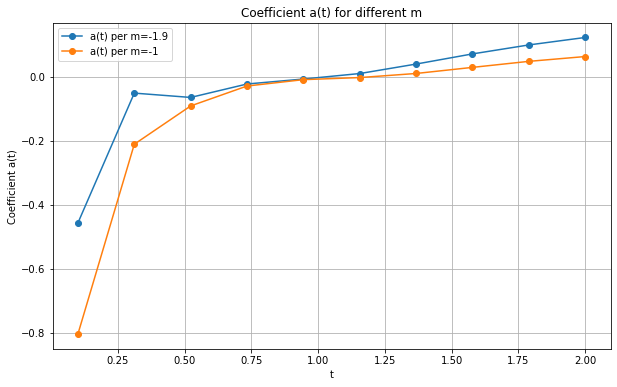

In [10]:
# Plottaggio dei coefficienti a(t) e b(t) per diversi valori di m
plot_coefficients_for_different_m(models, m_values, t_values)

In [ ]:

# Inizializza una lista vuota per salvare le magnetizzazioni
magnetizations = []

# Itera sui modelli e calcola la magnetizzazione per ciascuno
n_samples = 100  # Numero di campioni che vuoi generare per la magnetizzazione

for model in models:
    # Calcola la magnetizzazione per il modello attuale
    magnetization = model.calculate_magnetization(n_samples=n_samples)
    
    # Aggiungi la magnetizzazione al vettore
    magnetizations.append(magnetization)

# Ora la lista `magnetizations` contiene le magnetizzazioni per ogni modello
print("Magnetizzazioni per i vari modelli:", magnetizations)


In [ ]:

# Creare il plot
plt.figure(figsize=(10, 6))
plt.plot(m_values, magnetizations, marker='o', linestyle='-', color='b')

# Aggiungere etichette e titolo
plt.xlabel('Valori di m')
plt.ylabel('Magnetizzazione')
plt.title('Magnetizzazione in funzione di m')
plt.grid(True)
#plt.ylim(-1,1)
# Mostrare il grafico
plt.show()


In [ ]:
# Inizializza una lista vuota per salvare le suscettibilità
susceptibilities = []

# Itera sui modelli e calcola la suscettibilità per ciascuno
for model in models:
    # Calcola la suscettibilità per il modello attuale
    susceptibility = model.calculate_susceptibility(n_samples=n_samples)
    
    # Aggiungi la suscettibilità al vettore
    susceptibilities.append(susceptibility)

# Ora la lista `susceptibilities` contiene le suscettibilità per ogni modello
print("Suscettibilità per i vari modelli:", susceptibilities)


In [ ]:
# Creare il plot
plt.figure(figsize=(10, 6))
plt.plot(m_values, susceptibilities, marker='o', linestyle='-', color='b')

# Aggiungere etichette e titolo
plt.xlabel('Valori di m')
plt.ylabel('Susceptibility')
plt.title('Susceptibility as a function of m')
plt.grid(True)
#plt.ylim(-1,1)
# Mostrare il grafico
plt.show()


## Training for different parameters of the action

In [ ]:
lam = 0.4
m_list = [-1.5, -0.9, -0.2, 0.1, 0.7]

for m in m_list:
    training_samples = run_sq(100000, 50000, m=m, lam=lam)
    
    network = NetworkSinus().to(device)
    model = ActionModel(network)
    
    model.train_network(training_samples, 500, batch_size=1000)
    
    print('lambda= ', lam, ', m = ', m, ':')
    
    fig, ax1 = plt.subplots(figsize=(9,5))
    ax1.hist(model.generate_samples(100000).cpu().detach().numpy(), 
             bins=70, range=(-3.,3.), alpha=0.5, label='Generated samples')
    ax1.hist(training_samples.numpy(), 
             bins=70, range=(-3.,3.), alpha=0.5, label='Training samples')
    ax1.legend()
    ax1.set_ylabel('Number of samples')
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$\phi$')
    plt.show()
    
    plot_network(model.network, phi_max=2)
    print('-----------------------------------------------')

## Train and save networks

In [ ]:
folder_path =  r''


In [ ]:
lam = 0.4
m_list = [-1.5, -0.9, -0.2, 0.1, 0.7]

In [ ]:
i = 0
for m in m_list:
    training_samples = run_sq(100000, 50000, m=m, lam=lam)
    
    network = NetworkSinus().to(device)
    model = ActionModel(network)
    
    model.train_network(training_samples, 1000, batch_size=1000)
    
    i += 1
    torch.save({'model_state_dict': model.network.state_dict(),
                'optimizer_state_dict': model.optimizer.state_dict()}, folder_path+'sinus_net_{0}.pt'.format(i))

In [ ]:
i=0
for m in m_list:
    training_samples = run_sq(100000, 50000, m=m, lam=lam)
    
    network = NetworkSinus().to(device)
    model = ActionModel(network)
    i +=1
    checkpoint = torch.load(folder_path+'sinus_net_{0}.pt'.format(i))
    model.network.load_state_dict(checkpoint['model_state_dict'])
    model.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print('lambda= ', lam, ', m = ', m, ':')
    
    fig, ax1 = plt.subplots(figsize=(9,5))
    ax1.hist(model.generate_samples(100000).cpu().detach().numpy(), 
             bins=70, range=(-3.,3.), alpha=0.5, label='Generated samples')
    ax1.hist(training_samples.numpy(), 
             bins=70, range=(-3.,3.), alpha=0.5, label='Training samples')
    ax1.legend()
    ax1.set_ylabel('Number of samples')
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$\phi$')
    plt.show()
    
    plot_network(model.network, phi_max=2)
    print('-----------------------------------------------')

In [ ]:
model.network(training_samples[0:2], torch.tensor([[0.1],[0.5]], device=device), params_bool=True)

In [ ]:

# Parametri iniziali
m0 = -1  # Valore iniziale di m^2 (alla scala \mu_0)
lambda0 = 0.4  # Valore iniziale di \lambda (alla scala \mu_0)
mu_0 = 1  # Scala iniziale
mu_max = 1000000000  # Scala massima
num_steps = 500  # Numero di passi per la scala logaritmica

# Costante di un loop nel modello \phi^4
loop_factor = 16 * np.pi**2

# Inizializzazione di log(mu) e dei parametri
log_mu = np.linspace(np.log(mu_0), np.log(mu_max), num_steps)
m_squared = np.zeros(num_steps)
lambda_coupling = np.zeros(num_steps)

# Condizioni iniziali
m_squared[0] = m0
lambda_coupling[0] = lambda0

# Metodo di Eulero per risolvere le equazioni di flusso
for i in range(1, num_steps):
    delta_log_mu = log_mu[i] - log_mu[i-1]

    # Derivate delle equazioni di RG
    dm2_dlogmu = -lambda_coupling[i-1] / loop_factor
    dlambda_dlogmu = (3 * lambda_coupling[i-1]**2) / loop_factor

    # Aggiorniamo i valori di m^2 e lambda
    m_squared[i] = m_squared[i-1] + delta_log_mu * dm2_dlogmu
    lambda_coupling[i] = lambda_coupling[i-1] + delta_log_mu * dlambda_dlogmu

# Plot dei risultati
mu_values = np.exp(log_mu)
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.set_xlabel(r'$\mu$')
ax1.set_ylabel(r'$m^2(\mu)$', color='tab:blue')
ax1.plot(mu_values, m_squared, color='tab:blue', label=r'$m^2(\mu)$')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel(r'$\lambda(\mu)$', color='tab:red')  
ax2.plot(mu_values, lambda_coupling, color='tab:red', label=r'$\lambda(\mu)$')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()  
plt.title('Evoluzione di $m^2(\mu)$ e $\\lambda(\\mu)$ sotto il flusso RG')
plt.grid(True)
plt.show()


In [ ]:

from scipy.integrate import odeint


# Funzioni beta per m e lambda
def beta_functions(couplings, t):
    m, lam = couplings
    # Definisci le equazioni differenziali per il flusso di rinormalizzazione
    beta_m = -2 * m + lam / (4 * np.pi**2)
    beta_lambda = 3 * lam**2 / (4 * np.pi**2)
    return [beta_m, beta_lambda]

# Valori iniziali per m e lambda
initial_m = -1
initial_lambda = 0.1

# Range di t per l'integrazione (puoi pensare a t come la scala logaritmica di energia)
t_values = np.linspace(0, 10, 100)

# Risolvi il sistema di ODE usando odeint
solution = odeint(beta_functions, [initial_m, initial_lambda], t_values)

# Estrai le soluzioni per m(t) e lambda(t)
m_values = solution[:, 0]
lambda_values = solution[:, 1]

# Plot dei risultati
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t_values, m_values, label='m(t)')
plt.xlabel('t')
plt.ylabel('m(t)')
plt.title('Flusso di rinormalizzazione per m(t)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_values, lambda_values, label='lambda(t)')
plt.xlabel('t')
plt.ylabel('lambda(t)')
plt.title('Flusso di rinormalizzazione per lambda(t)')
plt.grid(True)

plt.tight_layout()
plt.show()